In [35]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

Define search space and evaluation parameters

In [36]:
limits = 10

# Define the search space for parameters a and b
a_values = np.linspace(-limits, limits, 100)  
b_values = np.linspace(-limits, limits, 100)

# Compute raw error and MSE over the (a, b) grid
error_grid = np.zeros((len(a_values), len(b_values)))
MSE_grid = np.zeros((len(a_values), len(b_values)))

# Generate equally spaced sample points in 1D for function evaluation
num_points = 100  
x_range_1D = np.linspace(-5, 5, num_points)

# Small constant to avoid log(0)
epsilon = 1e-6 

# Define Zero Threshold
manual_thresholds = {
    "Raw Error": 0.1,
    "MSE": 0.1,
}

# Define the true parameters for the Linear function
true_a, true_b = 1, 0

Define functions

In [37]:
def linear_model(x, a, b):
    x = np.array(x)
    return a * np.sum(x) + b * a -b**2*a + a**3 - b

def target_function(x):
    return linear_model(x, true_a, true_b)

def found_function(x, a, b):
    return linear_model(x, a, b)

Functions to get plot indexes

In [38]:
# Functions to find local and global minima
def find_local_minima(grid, a_vals, b_vals):
    local_min_mask = grid == scipy.ndimage.minimum_filter(grid, size=3)
    return [(a_vals[i], b_vals[j]) for i, j in np.argwhere(local_min_mask)]

def find_global_minimum(grid, a_vals, b_vals):
    min_index = np.unravel_index(np.argmin(grid), grid.shape)
    return (a_vals[min_index[0]], b_vals[min_index[1]])

Functions for the proposed idea

In [39]:
# Function to sample two points ensuring one is positive and the other is negative in raw error
def sample_valid_pairs(error_grid, a_vals, b_vals):
    while True:
        # Randomly sample two pairs of (a, b) values
        sampled_pair_1 = (random.choice(a_vals), random.choice(b_vals))
        sampled_pair_2 = (random.choice(a_vals), random.choice(b_vals))

        # Get their corresponding error values
        idx1 = (np.abs(a_vals - sampled_pair_1[0])).argmin(), (np.abs(b_vals - sampled_pair_1[1])).argmin()
        idx2 = (np.abs(a_vals - sampled_pair_2[0])).argmin(), (np.abs(b_vals - sampled_pair_2[1])).argmin()

        error_1 = error_grid[idx1]
        error_2 = error_grid[idx2]

        # Ensure one error is positive and the other is negative
        if error_1 * error_2 < 0:
            return sampled_pair_1, sampled_pair_2

In [40]:
def bisection_method(error_grid, a_vals, b_vals, sampled_pair_1, sampled_pair_2, tol=1e-3, max_iter=50):
    # Get the initial sampled points
    (a_low, b_low), (a_high, b_high) = sampled_pair_1, sampled_pair_2

    for _ in range(max_iter):
        # Compute midpoint
        a_mid = (a_low + a_high) / 2
        b_mid = (b_low + b_high) / 2

        # Get error at midpoint
        idx_mid = (np.abs(a_vals - a_mid)).argmin(), (np.abs(b_vals - b_mid)).argmin()
        error_mid = error_grid[idx_mid]

        # If error is sufficiently close to zero, stop
        if abs(error_mid) < tol:
            return a_mid, b_mid

        # Update bounds based on sign of error
        idx_low = (np.abs(a_vals - a_low)).argmin(), (np.abs(b_vals - b_low)).argmin()
        error_low = error_grid[idx_low]

        if error_mid * error_low < 0:  # Zero crossing lies between (a_low, b_low) and (a_mid, b_mid)
            a_high, b_high = a_mid, b_mid
        else:  # Zero crossing lies between (a_mid, b_mid) and (a_high, b_high)
            a_low, b_low = a_mid, b_mid

    return a_mid, b_mid  # Return the best approximation

In [41]:
# Random walk to find the minimum MSE from the estimated zero-error region
def random_walk_mse_with_path(a_start, b_start, mse_grid, a_vals, b_vals, step_size=0.8, max_iter=100000):
    a_current, b_current = a_start, b_start
    path = [(a_current, b_current)]  # Store path

    for _ in range(max_iter):
        idx_a = (np.abs(a_vals - a_current)).argmin()
        idx_b = (np.abs(b_vals - b_current)).argmin()
        mse_current = mse_grid[idx_a, idx_b]

        step_a = random.uniform(-step_size, step_size)
        step_b = random.uniform(-step_size, step_size)

        a_new, b_new = a_current + step_a, b_current + step_b
        a_new = np.clip(a_new, a_vals[0], a_vals[-1])
        b_new = np.clip(b_new, b_vals[0], b_vals[-1])

        idx_a_new = (np.abs(a_vals - a_new)).argmin()
        idx_b_new = (np.abs(b_vals - b_new)).argmin()
        mse_new = mse_grid[idx_a_new, idx_b_new]

        if mse_new < mse_current:
            a_current, b_current = a_new, b_new
            path.append((a_current, b_current))  # Store path

    return a_current, b_current, path

Show difference between fit and optimize

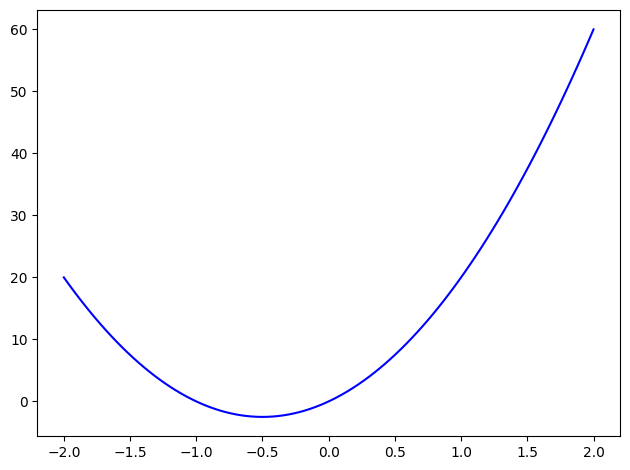

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def simple_model(x, a):
    x = np.array(x)
    return a * np.sum(x) + a * np.sum(x) ** 2

x_values = np.linspace(-2, 2, 100)

bench = np.array([simple_model([x], 10) for x in x_values])

plt.plot(x_values, bench, label=f"Function 1 (a={10:.2f})", color='blue')

plt.tight_layout()
plt.show()


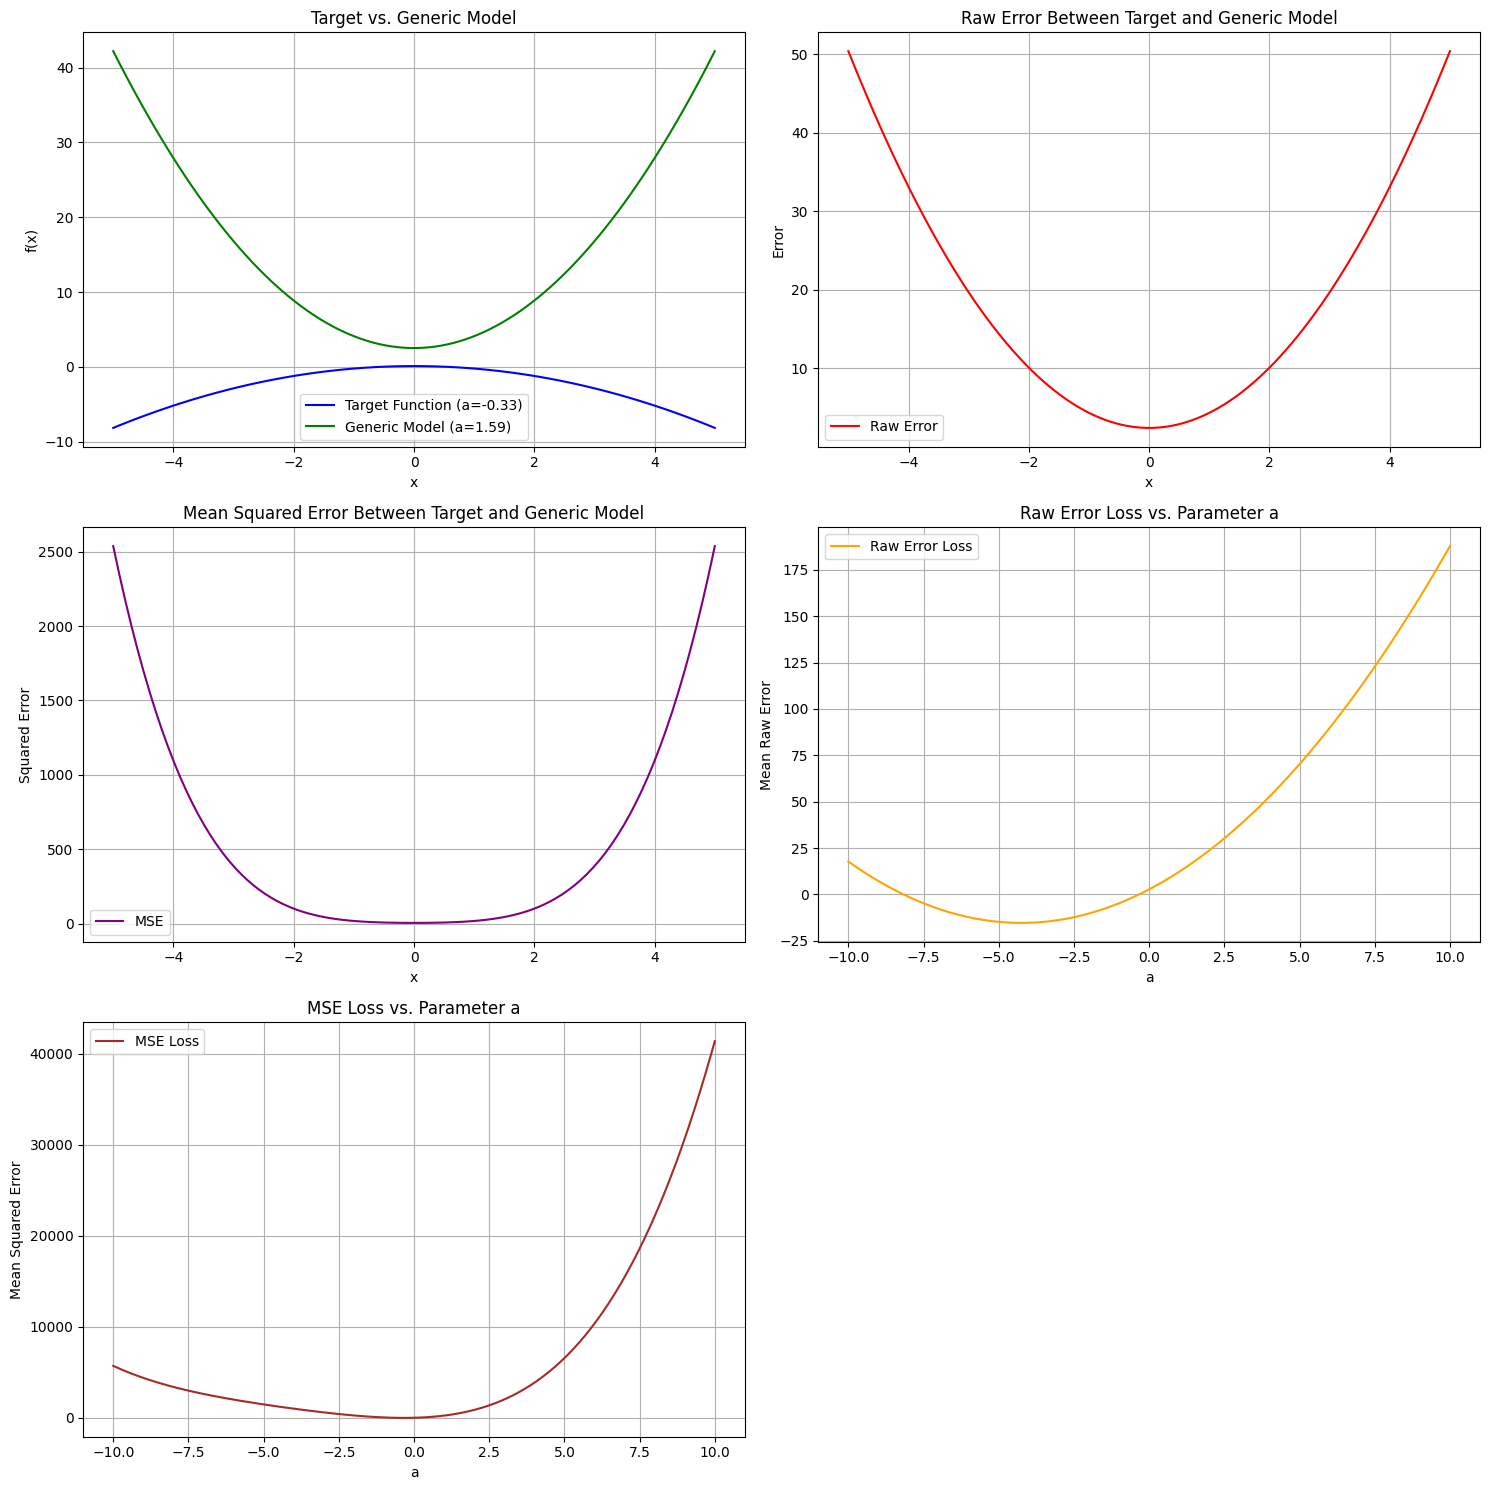

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def simple_model(x, a):
    #x = np.array(x)
    return a * x ** 2 + a ** 2

# Generate x values
x_values = np.linspace(-5, 5, 100)

# Generate target and generic model parameters
a_target = np.random.uniform(-2, 2)  # Target parameter
a_generic = np.random.uniform(-2, 2)  # Initial generic parameter

# Compute outputs for the target and generic models
y_target = np.array([simple_model(x, a_target) for x in x_values])
y_generic = np.array([simple_model(x, a_generic) for x in x_values])

# Compute raw error and MSE
raw_error = y_generic - y_target
mse_error = (y_generic - y_target) ** 2

# Prepare loss calculation for varying 'a'
a_range = np.linspace(-10, 10, 200)
raw_error_loss = []
mse_loss = []

for a in a_range:
    y_model = np.array([simple_model(x, a) for x in x_values])
    raw_error_loss.append(np.mean(y_model - y_target))
    mse_loss.append(np.mean((y_model - y_target) ** 2))

# Create plots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot target and generic functions
axs[0, 0].plot(x_values, y_target, label=f"Target Function (a={a_target:.2f})", color='blue')
axs[0, 0].plot(x_values, y_generic, label=f"Generic Model (a={a_generic:.2f})", color='green')
axs[0, 0].set_title("Target vs. Generic Model")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("f(x)")
axs[0, 0].grid(True)
axs[0, 0].legend()

# Plot raw error
axs[0, 1].plot(x_values, raw_error, label="Raw Error", color='red')
axs[0, 1].set_title("Raw Error Between Target and Generic Model")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("Error")
axs[0, 1].grid(True)
axs[0, 1].legend()

# Plot MSE
axs[1, 0].plot(x_values, mse_error, label="MSE", color='purple')
axs[1, 0].set_title("Mean Squared Error Between Target and Generic Model")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("Squared Error")
axs[1, 0].grid(True)
axs[1, 0].legend()

# Plot raw error loss vs a
axs[1, 1].plot(a_range, raw_error_loss, label="Raw Error Loss", color='orange')
axs[1, 1].set_title("Raw Error Loss vs. Parameter a")
axs[1, 1].set_xlabel("a")
axs[1, 1].set_ylabel("Mean Raw Error")
axs[1, 1].grid(True)
axs[1, 1].legend()

# Plot MSE loss vs a
axs[2, 0].plot(a_range, mse_loss, label="MSE Loss", color='brown')
axs[2, 0].set_title("MSE Loss vs. Parameter a")
axs[2, 0].set_xlabel("a")
axs[2, 0].set_ylabel("Mean Squared Error")
axs[2, 0].grid(True)
axs[2, 0].legend()

# Hide the unused subplot
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()


Verify when the optimal is not zero

In [84]:
#1) Remover um parametro e limitar a generalização do modelo

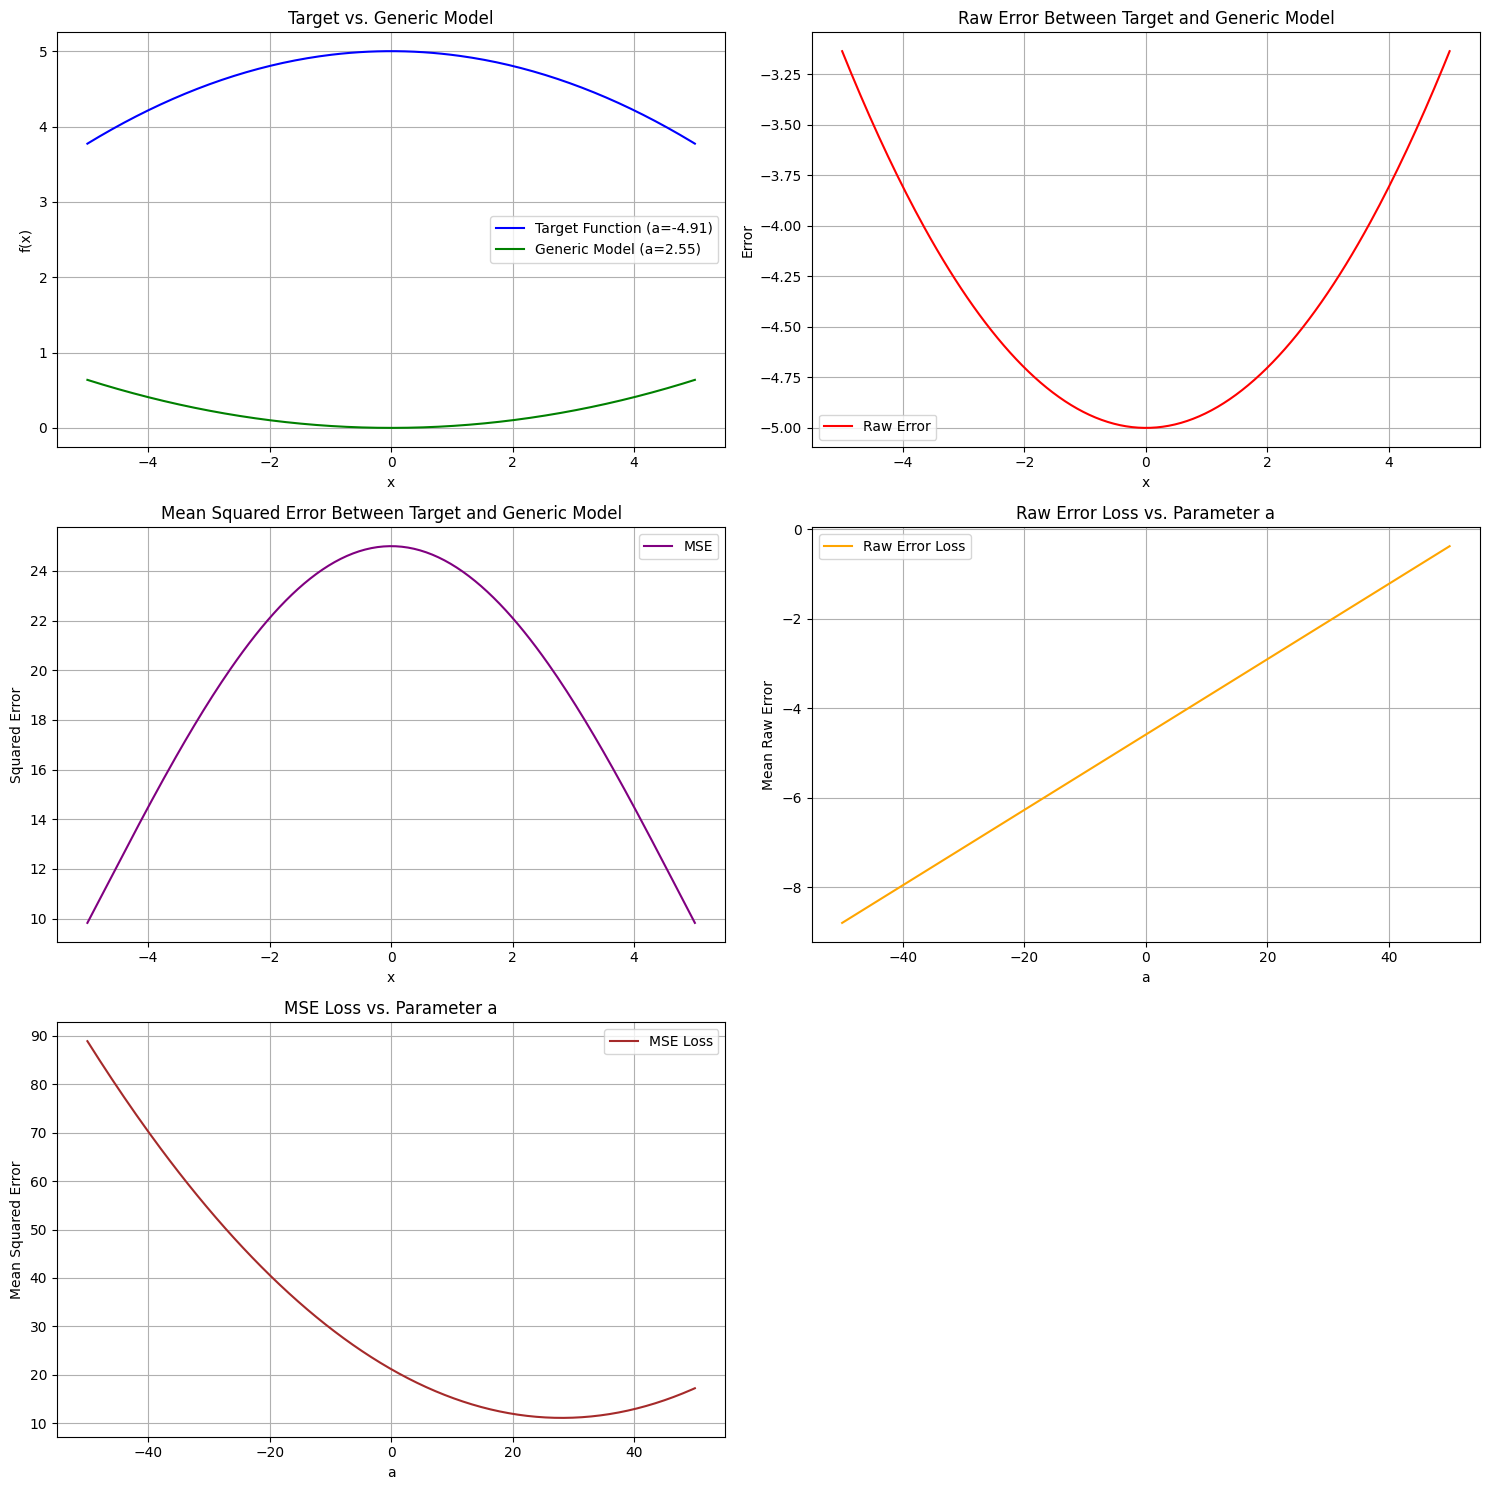

In [115]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def one_p_model(x, a, b = 5):
    #x = np.array(x)
    return a * x ** 2 / 100 + b


def two_p_model(x, a):
    #x = np.array(x)
    return a * x ** 2 / 100

# Generate x values
x_values = np.linspace(-5, 5, 100)

# Generate target and generic model parameters
a_target = np.random.uniform(-5, 5)  # Target parameter
a_generic = np.random.uniform(-5, 5)  # Initial generic parameter

# Compute outputs for the target and generic models
y_target = np.array([one_p_model(x, a_target) for x in x_values])
y_generic = np.array([two_p_model(x, a_generic) for x in x_values])

# Compute raw error and MSE
raw_error = y_generic - y_target
mse_error = (y_generic - y_target) ** 2

# Prepare loss calculation for varying 'a'
a_range = np.linspace(-50, 50, 200)
raw_error_loss = []
mse_loss = []

for a in a_range:
    y_model = np.array([two_p_model(x, a) for x in x_values])
    raw_error_loss.append(np.mean(y_model - y_target))
    mse_loss.append(np.mean((y_model - y_target) ** 2))

# Create plots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot target and generic functions
axs[0, 0].plot(x_values, y_target, label=f"Target Function (a={a_target:.2f})", color='blue')
axs[0, 0].plot(x_values, y_generic, label=f"Generic Model (a={a_generic:.2f})", color='green')
axs[0, 0].set_title("Target vs. Generic Model")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("f(x)")
axs[0, 0].grid(True)
axs[0, 0].legend()

# Plot raw error
axs[0, 1].plot(x_values, raw_error, label="Raw Error", color='red')
axs[0, 1].set_title("Raw Error Between Target and Generic Model")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("Error")
axs[0, 1].grid(True)
axs[0, 1].legend()

# Plot MSE
axs[1, 0].plot(x_values, mse_error, label="MSE", color='purple')
axs[1, 0].set_title("Mean Squared Error Between Target and Generic Model")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("Squared Error")
axs[1, 0].grid(True)
axs[1, 0].legend()

# Plot raw error loss vs a
axs[1, 1].plot(a_range, raw_error_loss, label="Raw Error Loss", color='orange')
axs[1, 1].set_title("Raw Error Loss vs. Parameter a")
axs[1, 1].set_xlabel("a")
axs[1, 1].set_ylabel("Mean Raw Error")
axs[1, 1].grid(True)
axs[1, 1].legend()

# Plot MSE loss vs a
axs[2, 0].plot(a_range, mse_loss, label="MSE Loss", color='brown')
axs[2, 0].set_title("MSE Loss vs. Parameter a")
axs[2, 0].set_xlabel("a")
axs[2, 0].set_ylabel("Mean Squared Error")
axs[2, 0].grid(True)
axs[2, 0].legend()

# Hide the unused subplot
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()


Find optimal points

In [43]:
true_values_1D = np.array([linear_model([x], true_a, true_b) for x in x_range_1D])

# Compute raw error and MSE over the (a, b) grid
error_grid = np.zeros((len(a_values), len(b_values)))
MSE_grid = np.zeros((len(a_values), len(b_values)))

for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        predicted_values = np.array([linear_model([x], a, b) for x in x_range_1D])
        error_grid[i, j] = np.mean(true_values_1D - predicted_values)  
        MSE_grid[i, j] = np.mean((true_values_1D - predicted_values) ** 2)  
        
sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid, a_values, b_values)
a_zero, b_zero = bisection_method(error_grid, a_values, b_values, sampled_pair_1, sampled_pair_2)
a_mse_min, b_mse_min, mse_path = random_walk_mse_with_path(a_zero, b_zero, MSE_grid, a_values, b_values)

found_values_1D = np.array([found_function(x, a_mse_min, b_mse_min) for x in x_range_1D])

error_grid_log = np.sign(error_grid) * np.log1p(np.abs(error_grid) + epsilon)
MSE_grid_log = np.log1p(MSE_grid + epsilon)

Plot process

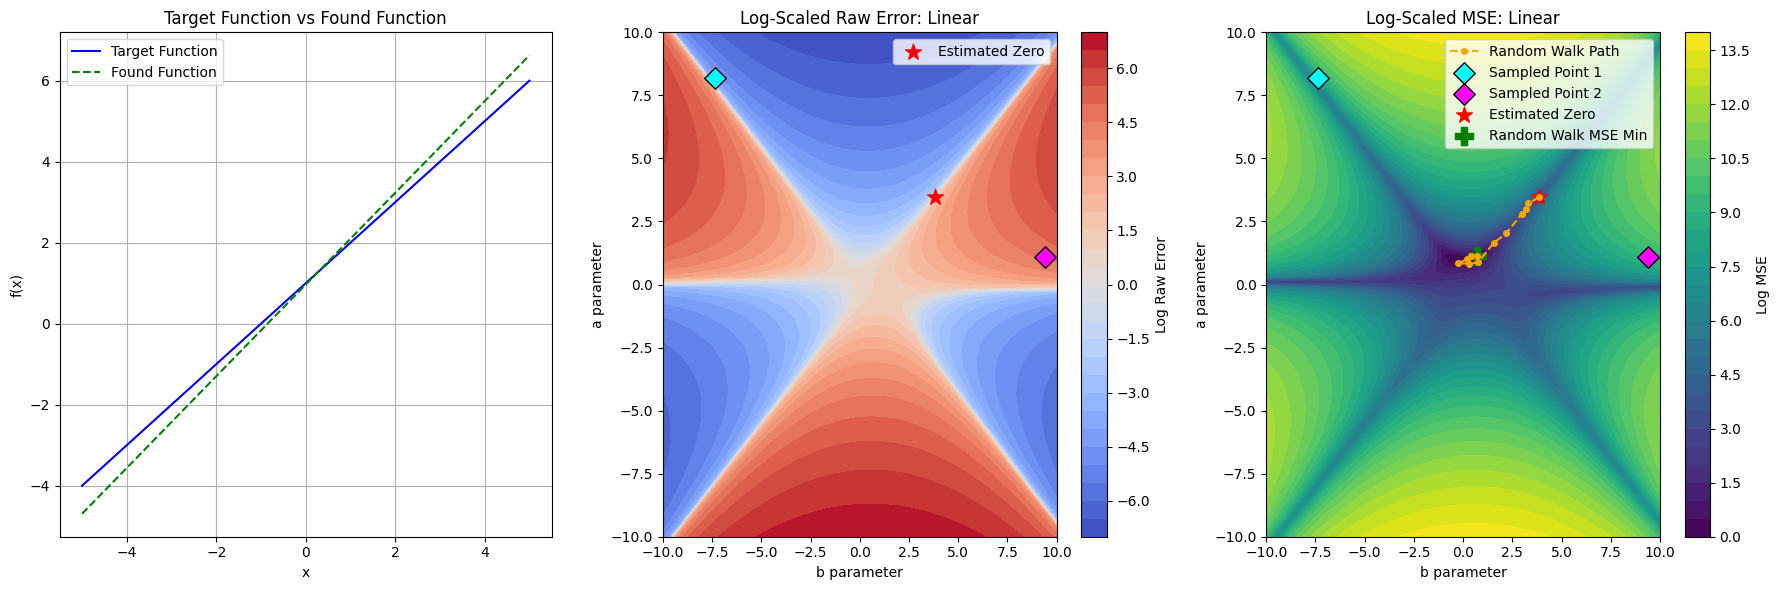

In [44]:
# Create plots with path visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Target function plot
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].plot(x_range_1D, found_values_1D, color='green', linestyle='--', label="Found Function")
axs[0].set_title(f"Target Function vs Found Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Raw error contour plot
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")
axs[1].scatter(b_zero, a_zero, color="red", marker="*", s=140, label="Estimated Zero")
axs[1].set_title(f"Log-Scaled Raw Error: Linear")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

axs[1].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[1].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

# MSE contour plot with random walk path
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

# Mark the path of the random walk
mse_path_array = np.array(mse_path)
axs[2].plot(mse_path_array[:, 1], mse_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="Random Walk Path")

axs[2].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[2].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

# Mark start and end points
axs[2].scatter(b_zero, a_zero, color="red", marker="*", s=140, label="Estimated Zero")
axs[2].scatter(b_mse_min, a_mse_min, color="green", marker="P", s=160, label="Random Walk MSE Min")

axs[2].set_title(f"Log-Scaled MSE: Linear")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()